# Check the posterior distribution of the implied distance

Given the expressions for the implied distance D and radial velocity $V_r$:

$D = \frac{ \hat{n} \cdot (\vec{R_{0}} \times \vec{V_{0}})}{\vec{R_ 0} \
\cdot (\hat{n} \times \vec{\mu})}$

$V_r = \frac{D \vec{V_ 0} \cdot (\hat{n} \times \vec{\mu}) - \vec{\mu} \
\cdot (\vec{R_ 0} \times \vec{V_o})}{\vec{R_ 0} \cdot (\hat{n} \times \
\vec{\mu})}$

and the expresion for the implied distance error assuming uncorrelated errors and only taking into account the proper motion error:


$\sigma_{\overline{\omega_I}} = \frac{\sqrt{(\vec{R_o} \cdot (\hat{n} \times \hat{\mu_{\delta}})\sigma_{\mu_\delta})^2 + (\vec{R_o} \cdot (\hat{n} \times \hat{\mu_{\alpha*}})\sigma_{\mu_{\alpha}})^2}}{\hat{n} \cdot (\vec{R_o} \times \hat{V_o})} $


you can see that there exists an entire range of solution were $\hat{n}$ is perpendicular to $(\vec{R_o} \times \hat{V_o})$ which could cause problems. 

For this reason I will sample over the uncertainties in 100 random directions of the sky to get the posterior distribution of the errors, instead of relying on this expression

In [116]:
# imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

from astroquery.gaia import Gaia
import random
import healpy as hp

from matplotlib.gridspec import GridSpec

In [5]:
# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *


# Query the gaia archive for 100 random sources

In [6]:

def query_random_objects(healpix_level=6, num_objects=100, login=False, username='', password=''):
    """
    Retrieve random Gaia DR3 objects homogeneously distributed in the sky, using HEALPix pixelation.
    
    Parameters:
    -----------
    healpix_level : int, default=6
        HEALPix level to use for pixelation. Level 6 corresponds to 49,152 pixels, ensuring even sky coverage.
        
    num_objects : int, default=100
        The number of random objects to retrieve.
        
    login : bool, default=False
        Whether to log in to the Gaia archive (required for larger queries).
        
    username : str, default=''
        Username for logging into the Gaia archive (used if login=True).
        
    password : str, default=''
        Password for logging into the Gaia archive (used if login=True).
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the Gaia DR3 data for the randomly selected objects.
    """
    
    # Number of pixels for the given healpix level
    num_pixels = hp.nside2npix(2**healpix_level)
    
    # Randomly select HEALPix pixels
    random_healpix_pixels = random.sample(range(num_pixels), num_objects)
    
    # Optionally log into Gaia archive for large queries
    if login:
        Gaia.login(user=username, password=password)
        
        # Clean up any excess jobs
        jobs = [job for job in Gaia.list_async_jobs()]
        job_ids = [job.jobid for job in jobs]
        if len(job_ids) > 5:
            Gaia.remove_jobs(job_ids)
    
    Gaia.ROW_LIMIT = -1  # No row limit
    
    all_results = []
    
    for healpix_pixel in random_healpix_pixels:
        # Calculate source ID range for the selected HEALPix pixel
        factor = (2**35) * (4**(12 - healpix_level))  # Scaling factor based on level
        source_id_min = int(healpix_pixel * factor)
        source_id_max = int((healpix_pixel + 1) * factor)
        
        # ADQL query for the specific HEALPix pixel
        job = Gaia.launch_job_async(f"""
        SELECT gs.source_id, gs.l, gs.b, gs.ra, gs.ra_error, gs.dec, gs.dec_error, 
               gs.parallax, gs.parallax_error, gs.pmra, gs.pmra_error, gs.pmdec, gs.pmdec_error,
               gs.astrometric_params_solved, gs.astrometric_excess_noise, gs.astrometric_excess_noise_sig, 
               gs.ruwe, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag
        FROM gaiadr3.gaia_source AS gs
        WHERE gs.source_id >= {source_id_min} 
          AND gs.source_id < {source_id_max}
          AND gs.ruwe < 1.4
        """)
        
        result = job.get_results()
        all_results.append(result.to_pandas())
    
    # Concatenate all the individual results into one DataFrame
    combined_results = pd.concat(all_results, ignore_index=True)
    
    return combined_results


In [7]:
def query_random_objects_by_source_id(healpix_level=2, num_objects=100, login=False, username='', password=''):
    """
    Retrieve random Gaia DR3 objects homogeneously distributed in the sky by selecting random source_ids 
    from HEALPix pixels and querying the Gaia database in a single query.
    
    Parameters:
    -----------
    healpix_level : int, default=6
        HEALPix level to use for pixelation. Level 6 corresponds to 49,152 pixels, ensuring even sky coverage.
        
    num_objects : int, default=100
        The number of random objects to retrieve.
        
    login : bool, default=False
        Whether to log in to the Gaia archive (required for larger queries).
        
    username : str, default=''
        Username for logging into the Gaia archive (used if login=True).
        
    password : str, default=''
        Password for logging into the Gaia archive (used if login=True).
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the Gaia DR3 data for the randomly selected objects.
    """
    
    # Number of pixels for the given healpix level
    num_pixels = hp.nside2npix(2**healpix_level)
    
    # Randomly select HEALPix pixels
    random_healpix_pixels = random.sample(range(num_pixels), num_objects)
    
    # Optionally log into Gaia archive for large queries
    if login:
        Gaia.login(user=username, password=password)
        
        # Clean up any excess jobs
        jobs = [job for job in Gaia.list_async_jobs()]
        job_ids = [job.jobid for job in jobs]
        if len(job_ids) > 5:
            Gaia.remove_jobs(job_ids)
    
    Gaia.ROW_LIMIT = -1  # No row limit
    
    # List to store the randomly selected source_ids
    selected_source_ids = []
    
    for healpix_pixel in random_healpix_pixels:
        # Calculate source ID range for the selected HEALPix pixel
        factor = (2**35) * (4**(12 - healpix_level))  # Scaling factor based on level
        source_id_min = int(healpix_pixel * factor)
        source_id_max = int((healpix_pixel + 1) * factor)
        
        # Randomly select a source_id within this range
        random_source_id = random.randint(source_id_min, source_id_max - 1)
        selected_source_ids.append(random_source_id)
    
    # Convert the selected source_ids list into a string for the query
    source_ids_str = ', '.join(map(str, selected_source_ids))
    print(source_ids_str)
    
    # ADQL query to retrieve data based on the selected source_ids
    query = f"""
    SELECT gs.source_id, gs.l, gs.b, gs.ra, gs.ra_error, gs.dec, gs.dec_error, 
           gs.parallax, gs.parallax_error, gs.pmra, gs.pmra_error, gs.pmdec, gs.pmdec_error,
           gs.astrometric_params_solved, gs.astrometric_excess_noise, gs.astrometric_excess_noise_sig, 
           gs.ruwe, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag
    FROM gaiadr3.gaia_source AS gs
    WHERE gs.source_id IN ({source_ids_str})
    """
    
    # Launch the job to query Gaia database
    job = Gaia.launch_job_async(query)
    
    # Get the results
    gaia_results = job.get_results()
    
    # Convert the results to a pandas DataFrame and return
    return gaia_results.to_pandas()


In [8]:
data = query_random_objects(healpix_level=9, num_objects=100, login=False)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [131]:
data

,SOURCE_ID,l,b,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_params_solved,astrometric_excess_noise,astrometric_excess_noise_sig,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,64284085485774592,167.153062,-26.588485,54.945792,0.080650,21.485857,0.057617,1.787394,0.098495,9.871339,0.102022,-6.042144,0.075145,31,0.000000,0.000000,0.979847,17.271133,18.469831,16.195560
1,64284085486158720,167.158497,-26.598708,54.942354,0.104171,21.475000,0.070691,0.536715,0.125064,-0.061712,0.124019,-1.763452,0.090130,95,0.000000,0.000000,0.979713,17.571114,18.095108,16.875776
2,64284119845612160,167.136762,-26.609249,54.919239,0.739763,21.480107,0.606211,-0.488544,0.954215,0.530765,1.141711,-0.381894,0.855654,95,1.854640,1.475079,1.082048,20.355312,20.463604,19.745253
3,64284188564989056,167.161303,-26.583895,54.954983,0.076192,21.484360,0.052048,0.468276,0.092634,4.339887,0.091953,2.025867,0.066344,31,0.000000,0.000000,1.051201,16.995102,17.448029,16.357088
4,64284252988739840,167.133856,-26.574216,54.942267,0.153200,21.507945,0.112397,1.182893,0.188274,-1.245221,0.204672,-0.246581,0.137671,31,0.387499,1.092979,1.105187,18.341509,19.286791,17.285717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50404,5927453961165608320,330.964464,-8.648770,253.247197,0.143091,-57.694640,0.114446,-0.089391,0.186902,-1.800792,0.193961,-3.462441,0.169824,31,0.400349,0.917097,1.049204,18.625183,19.135723,18.074535
50405,5927453961165609600,330.968376,-8.646628,253.248565,0.145464,-57.690280,0.111717,0.073156,0.180648,0.258210,0.185065,-1.728521,0.163469,31,0.000000,0.000000,1.031097,18.606295,19.143305,17.958271
50406,5927453961165611648,330.967629,-8.639994,253.237993,0.090398,-57.686727,0.071501,0.120666,0.115425,-2.690343,0.124092,-6.804597,0.106925,31,0.000000,0.000000,0.968807,17.859653,18.406664,17.208227
50407,5927453961172854528,330.968723,-8.640522,253.240026,0.610311,-57.686210,0.562018,-0.486257,0.846034,-5.906097,0.975986,-4.543377,0.970741,95,0.000000,0.000000,0.969154,20.547628,21.284624,19.925184


In [9]:

def implied_calculations_single_2(ra, dec, pmra, pmdec, pmra_error, pmdec_error):
    # Convert positions to radians
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)

    # Convert proper motions to radians per second
    masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
    pmra_rad_s = pmra * masyr_to_radsec
    pmdec_rad_s = pmdec * masyr_to_radsec
    epmra_rad_s = pmra_error * masyr_to_radsec
    epmdec_rad_s = pmdec_error* masyr_to_radsec

    # Compute R0 and V0 in SI units (meters and meters per second)
    print('Computing R0 and V0...')
    R0_SI, V0_SI = compute_R0_V0_SI()

    # Run optimized function
    print('Computing distances and velocities...')
    plx_opt, eplx_opt, VGCR_opt, VR_opt = getdist_vectorized(
        ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, epmra_rad_s, epmdec_rad_s, R0_SI, V0_SI
    )
    print('Distances and velocities computed successfully!')
    # Post-process the results
    plx_mas, eplx_mas, VGCR_kms, VR_kms = post_process_results(plx_opt, eplx_opt, VGCR_opt, VR_opt)

    return plx_mas, eplx_mas, VGCR_kms, VR_kms


## Sky distribution of sample

In [10]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})

# set the path to save plots
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/implementing_sill_selections'

In [130]:
data.columns

Index(['SOURCE_ID', 'l', 'b', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'astrometric_params_solved', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'ruwe', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag'],
      dtype='object')

In [ ]:
da

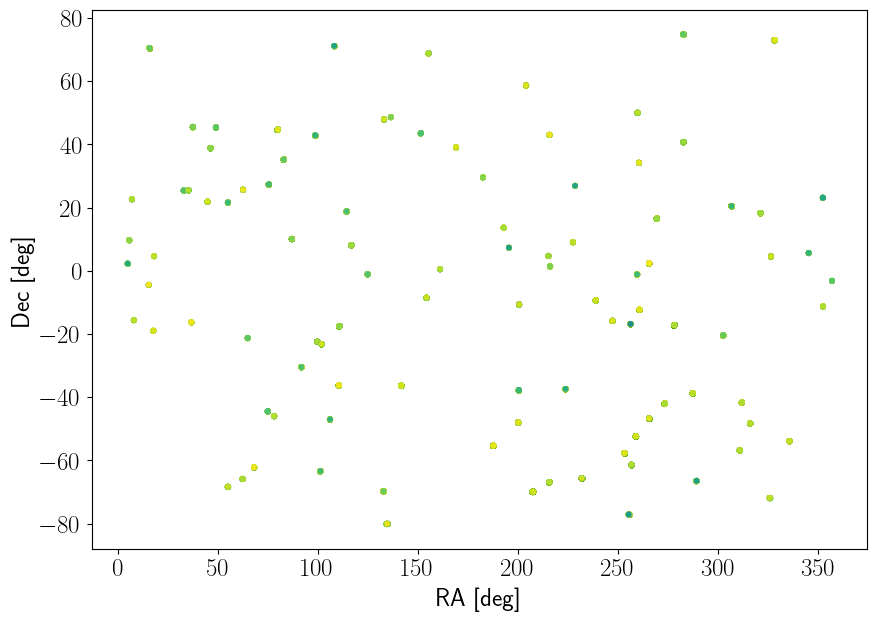

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(data['ra'], data['dec'], s=10, c=data['phot_g_mean_mag'], cmap='viridis')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()

## Sample over the proper motion error assuming a Gaussian distribution, first with one star

,SOURCE_ID,l,b,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_params_solved,astrometric_excess_noise,astrometric_excess_noise_sig,ruwe,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,64284085485774592,167.153062,-26.588485,54.945792,0.080650,21.485857,0.057617,1.787394,0.098495,9.871339,0.102022,-6.042144,0.075145,31,0.000000,0.000000,0.979847,17.271133,18.469831,16.195560
1,64284085486158720,167.158497,-26.598708,54.942354,0.104171,21.475000,0.070691,0.536715,0.125064,-0.061712,0.124019,-1.763452,0.090130,95,0.000000,0.000000,0.979713,17.571114,18.095108,16.875776
2,64284119845612160,167.136762,-26.609249,54.919239,0.739763,21.480107,0.606211,-0.488544,0.954215,0.530765,1.141711,-0.381894,0.855654,95,1.854640,1.475079,1.082048,20.355312,20.463604,19.745253
3,64284188564989056,167.161303,-26.583895,54.954983,0.076192,21.484360,0.052048,0.468276,0.092634,4.339887,0.091953,2.025867,0.066344,31,0.000000,0.000000,1.051201,16.995102,17.448029,16.357088
4,64284252988739840,167.133856,-26.574216,54.942267,0.153200,21.507945,0.112397,1.182893,0.188274,-1.245221,0.204672,-0.246581,0.137671,31,0.387499,1.092979,1.105187,18.341509,19.286791,17.285717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50404,5927453961165608320,330.964464,-8.648770,253.247197,0.143091,-57.694640,0.114446,-0.089391,0.186902,-1.800792,0.193961,-3.462441,0.169824,31,0.400349,0.917097,1.049204,18.625183,19.135723,18.074535
50405,5927453961165609600,330.968376,-8.646628,253.248565,0.145464,-57.690280,0.111717,0.073156,0.180648,0.258210,0.185065,-1.728521,0.163469,31,0.000000,0.000000,1.031097,18.606295,19.143305,17.958271
50406,5927453961165611648,330.967629,-8.639994,253.237993,0.090398,-57.686727,0.071501,0.120666,0.115425,-2.690343,0.124092,-6.804597,0.106925,31,0.000000,0.000000,0.968807,17.859653,18.406664,17.208227
50407,5927453961172854528,330.968723,-8.640522,253.240026,0.610311,-57.686210,0.562018,-0.486257,0.846034,-5.906097,0.975986,-4.543377,0.970741,95,0.000000,0.000000,0.969154,20.547628,21.284624,19.925184


In [128]:
Table.from_pandas(data).write('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/random_objects_homogeneous_sky.fits', format='fits', overwrite=True)

In [12]:
random_star = data.sample(1)

In [17]:
random_star['ra']

28615    79.90607
Name: ra, dtype: float64

In [20]:
# get the distribution of distances by sampling from the errors

plx_m_distribution = []
pmra_distribution = []
pmdec_distribution = []
# define gaussian distribution for pmra and pmdec based on the errors
for i in range(1000):
    pmra = np.random.normal(random_star['pmra'], random_star['pmra_error'])
    pmdec = np.random.normal(random_star['pmdec'], random_star['pmdec_error'])

    # calculate the distance
    plx_mas, eplx_mas, VGCR_kms, VR_kms = implied_calculations_single(random_star['ra'].values, random_star['dec'].values, pmra, pmdec, random_star['pmra_error'].values, random_star['pmdec_error'].values)

    plx_m_distribution.append(plx_mas)
    pmra_distribution.append(pmra)
    pmdec_distribution.append(pmdec)


Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

In [23]:
# get the central value and the error

 # calculate the distance
plx_mas, eplx_mas, VGCR_kms, VR_kms = implied_calculations_single(random_star['ra'].values, random_star['dec'].values, random_star['pmra'].values, random_star['pmdec'].values, random_star['pmra_error'].values, random_star['pmdec_error'].values)


Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!


In [14]:
from scipy.stats import norm

In [31]:
1/plx_mas.value[0]

np.float64(18.54763415871906)

In [43]:
norm.pdf(1/plx_mas, 1/plx_mas, np.abs(1/eplx_mas))

array([0.00193795])

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/2448690786.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/2448690786.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')


20 19


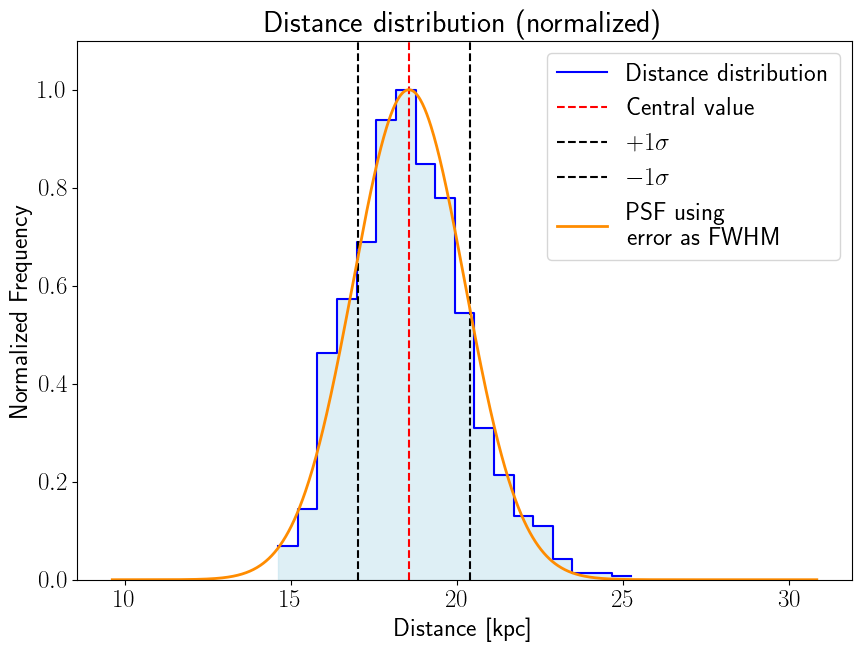

In [90]:
# Plot the distribution of the distance
plt.figure(figsize=(10, 7))

# Histogram: Compute the histogram data and normalize it to peak at 1
hist_data, bins = np.histogram(1/np.array(plx_m_distribution), bins='scott')
max_hist = np.max(hist_data)  # Find the peak value of the histogram

# Normalize the histogram to peak at 1
hist_data = hist_data/ max_hist
print(len(bins), len(hist_data))
plt.step(bins[:-1], hist_data, where='post', color='blue', label='Distance distribution')  # Step plot for histogram
plt.fill_between(bins[:-1], hist_data, step='post', color='lightblue', alpha=0.4)




# Plot vertical lines for the central value and error range
plt.axvline(1/plx_mas.value, color='red', linestyle='--', label='Central value')
plt.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
plt.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')

# Compute sigma assuming 1/eplx_mas as the FWHM
sigma = 1/(2*np.sqrt(2*np.log(2)) * np.abs(eplx_mas.value))

# Generate x values for the Gaussian distribution
x = np.linspace(min(bins)-5, max(bins)+5, 1000)

# Gaussian distribution: Compute the PDF and normalize it to peak at 1
distance_error = (np.abs(1/(plx_mas.value + eplx_mas.value)) - np.abs(1/(plx_mas.value - eplx_mas.value)) )/2
gaussian_data = norm.pdf(x, 1/plx_mas.value, distance_error ) #sigma)
gaussian_data = gaussian_data/np.max(gaussian_data)  # Normalize Gaussian to peak at 1

# Plot the normalized Gaussian distribution
plt.plot(x, gaussian_data, color='darkorange', linewidth =2,  label='PSF using \n error as FWHM')

plt.xlabel('Distance [kpc]')
plt.ylabel('Normalized Frequency')
plt.title('Distance distribution (normalized)')
plt.legend()
plt.ylim(0, 1.1)

# Save and show the plot
plt.savefig(os.path.join(plots_path, 'distance_distribution.png'))
plt.show()

## New plot with sky position, proper motion vector with errors

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/2611926474.py:16: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/2611926474.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')


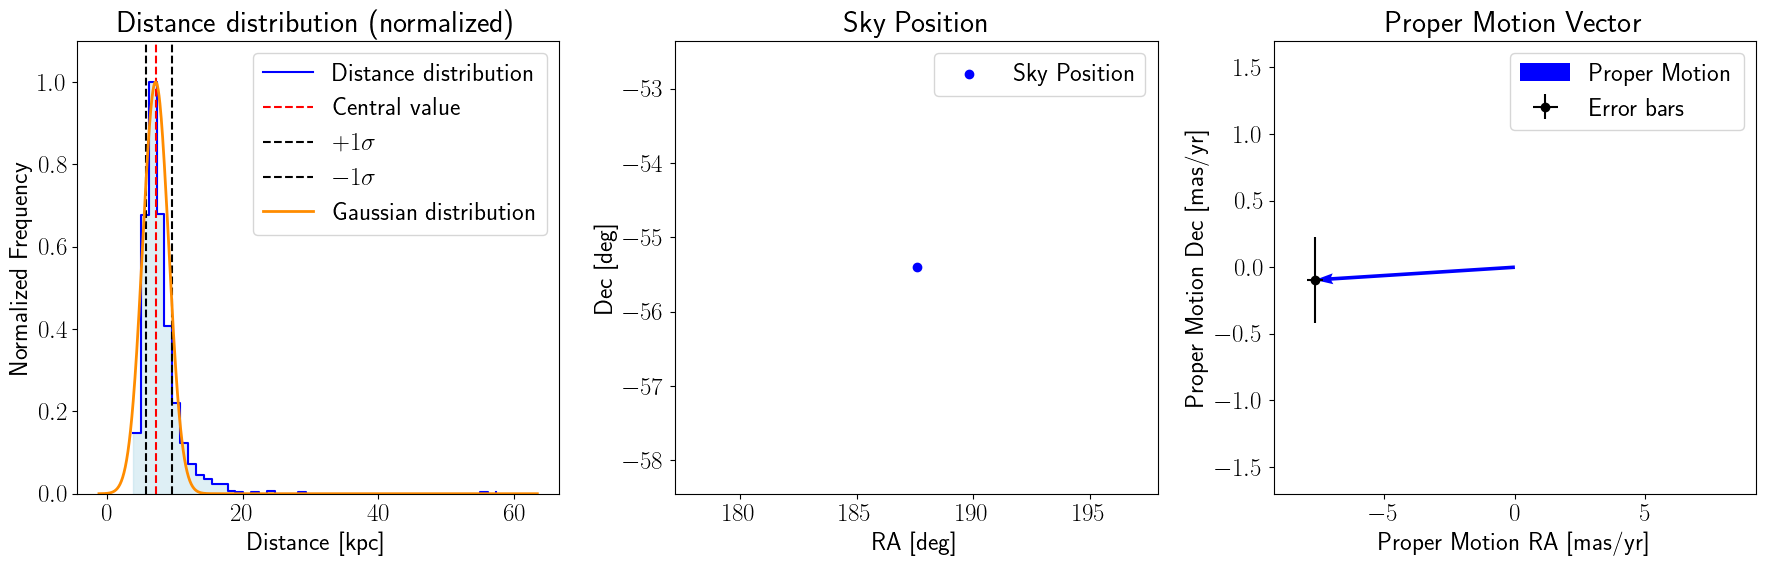

In [115]:
# Create a figure with 3 panels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# ======== Panel 1: Distance distribution ========
# Histogram: Compute the histogram data and normalize it to peak at 1
hist_data, bins = np.histogram(1 / np.array(plx_m_distribution), bins='scott')
max_hist = np.max(hist_data)  # Find the peak value of the histogram

# Normalize the histogram to peak at 1
hist_data = hist_data / max_hist
ax1.step(bins[:-1], hist_data, where='post', color='blue', label='Distance distribution')  # Step plot for histogram
ax1.fill_between(bins[:-1], hist_data, step='post', color='lightblue', alpha=0.4)

# Plot vertical lines for the central value and error range
ax1.axvline(1/plx_mas.value, color='red', linestyle='--', label='Central value')
ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')

# Compute sigma assuming 1/eplx_mas as the FWHM
sigma = 1 / (2 * np.sqrt(2 * np.log(2)) * np.abs(eplx_mas.value))

# Generate x values for the Gaussian distribution
x = np.linspace(min(bins) - 5, max(bins) + 5, 1000)

# Gaussian distribution: Compute the PDF and normalize it to peak at 1
distance_error = (np.abs(1/(plx_mas.value + eplx_mas.value)) - np.abs(1/(plx_mas.value - eplx_mas.value))) / 2
gaussian_data = norm.pdf(x, 1/plx_mas.value, distance_error)
gaussian_data /= np.max(gaussian_data)  # Normalize Gaussian to peak at 1

# Plot the normalized Gaussian distribution
ax1.plot(x, gaussian_data, color='darkorange', linewidth=2, label='Gaussian distribution')

# Labels, title, and legend for Panel 1
ax1.set_xlabel('Distance [kpc]')
ax1.set_ylabel('Normalized Frequency')
ax1.set_title('Distance distribution (normalized)')
ax1.legend()
ax1.set_ylim(0, 1.1)

# ======== Panel 2: Sky Position (RA vs Dec) ========
ax2.scatter(random_star['ra'], random_star['dec'], color='blue', label='Sky Position')
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('Dec [deg]')
ax2.set_title('Sky Position')
ax2.legend()

# ======== Panel 3: Proper Motion Vector ========
ax3.quiver(0, 0, random_star['pmra'], random_star['pmdec'], angles='xy', scale_units='xy', scale=1, color='blue', label='Proper Motion')
ax3.errorbar(random_star['pmra'], random_star['pmdec'], xerr=random_star['pmra_error'], yerr=random_star['pmdec_error'], fmt='o', color='black', label='Error bars')

# Set limits and labels for the proper motion panel
ax3.set_xlim(-max(random_star['pmra'] + random_star['pmra_error'], random_star['pmdec'] + random_star['pmdec_error']), max(random_star['pmra'] + random_star['pmra_error'], random_star['pmdec'] + random_star['pmdec_error']))
ax3.set_ylim(-max(random_star['pmra'] + random_star['pmra_error'], random_star['pmdec'] + random_star['pmdec_error']), max(random_star['pmra'] + random_star['pmra_error'], random_star['pmdec'] + random_star['pmdec_error']))
ax3.set_xlabel('Proper Motion RA [mas/yr]')
ax3.set_ylabel('Proper Motion Dec [mas/yr]')
ax3.set_title('Proper Motion Vector')
ax3.legend()
range_y = np.abs(random_star['pmdec']) + 5*random_star['pmdec_error']
range_x = np.abs(random_star['pmra']) + 5*random_star['pmra_error']
ax3.set_ylim(-range_y, range_y)
ax3.set_xlim(-range_x , range_x )

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig(os.path.join(plots_path, 'distance_sky_pm_distribution.png'))
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1945622742.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1945622742.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')


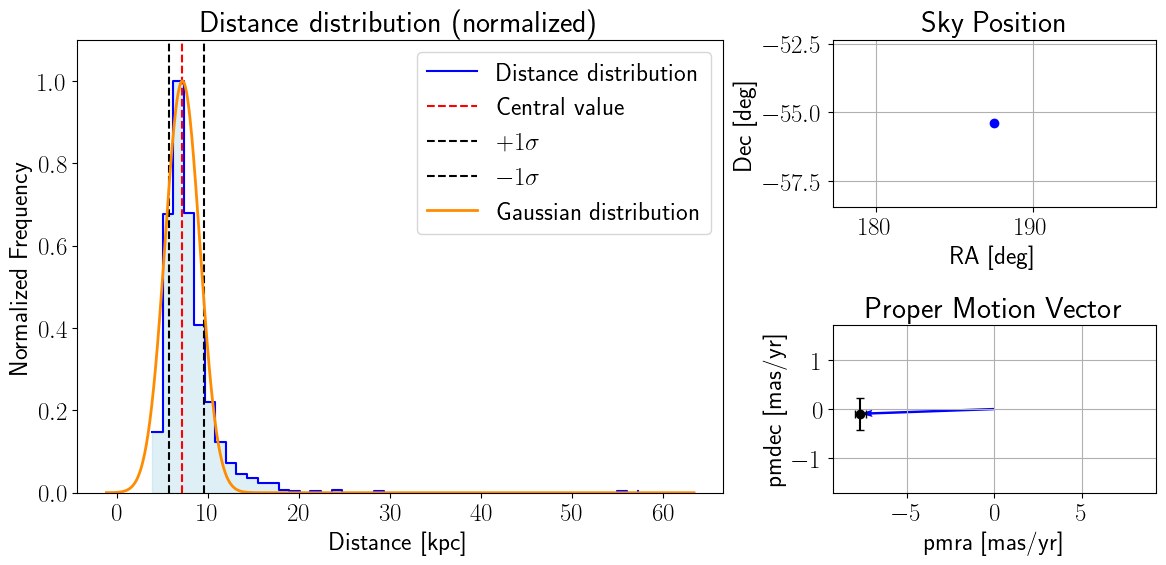

In [123]:


# Assuming plx_m_distribution, plx_mas, eplx_mas, ra, dec, random_star, and plots_path are defined

# Create a figure with GridSpec to customize the layout
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, width_ratios=[2, 1])  # Main plot on the left, two smaller plots on the right

# ======== Panel 1: Distance distribution ========
ax1 = fig.add_subplot(gs[:, 0])  # Use the first column for the full height of panel 1

# Histogram: Compute the histogram data and normalize it to peak at 1
hist_data, bins = np.histogram(1 / np.array(plx_m_distribution), bins='scott')
max_hist = np.max(hist_data)  # Find the peak value of the histogram

# Normalize the histogram to peak at 1
hist_data = hist_data / max_hist
ax1.step(bins[:-1], hist_data, where='post', color='blue', label='Distance distribution')  # Step plot for histogram
ax1.fill_between(bins[:-1], hist_data, step='post', color='lightblue', alpha=0.4)

# Plot vertical lines for the central value and error range
ax1.axvline(1/plx_mas.value, color='red', linestyle='--', label='Central value')
ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')

# Compute sigma assuming 1/eplx_mas as the FWHM
sigma = 1 / (2 * np.sqrt(2 * np.log(2)) * np.abs(eplx_mas.value))

# Generate x values for the Gaussian distribution
x = np.linspace(min(bins) - 5, max(bins) + 5, 1000)

# Gaussian distribution: Compute the PDF and normalize it to peak at 1
distance_error = (np.abs(1/(plx_mas.value + eplx_mas.value)) - np.abs(1/(plx_mas.value - eplx_mas.value))) / 2
gaussian_data = norm.pdf(x, 1/plx_mas.value, distance_error)
gaussian_data /= np.max(gaussian_data)  # Normalize Gaussian to peak at 1

# Plot the normalized Gaussian distribution
ax1.plot(x, gaussian_data, color='darkorange', linewidth=2, label='Gaussian distribution')

# Labels, title, and legend for Panel 1
ax1.set_xlabel('Distance [kpc]')
ax1.set_ylabel('Normalized Frequency')
ax1.set_title('Distance distribution (normalized)')
ax1.legend()
ax1.set_ylim(0, 1.1)

# ======== Panel 2: Sky Position (RA vs Dec) ========
ax2 = fig.add_subplot(gs[0, 1])  # First smaller plot in the top-right
ax2.scatter(random_star['ra'], random_star['dec'], color='blue', label='Sky Position')
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('Dec [deg]')
ax2.set_title('Sky Position')
ax2.grid(True)
#ax2.legend()

# ======== Panel 3: Proper Motion Vector ========
ax3 = fig.add_subplot(gs[1, 1])  # Second smaller plot in the bottom-right

# Extract proper motion data from random_star table
pmra = random_star['pmra']
pmdec = random_star['pmdec']
pmra_error = random_star['pmra_error']
pmdec_error = random_star['pmdec_error']

# Proper motion quiver plot and error bars
ax3.quiver(0, 0, pmra, pmdec, angles='xy', scale_units='xy', scale=1, color='blue', label='Proper Motion')
ax3.errorbar(pmra, pmdec, xerr=pmra_error, yerr=pmdec_error, fmt='o', color='black', label='Error bars', capsize=3)

# Set limits and labels for the proper motion panel
range_y = np.abs(pmdec) + 5 * pmdec_error
range_x = np.abs(pmra) + 5 * pmra_error
ax3.set_xlim(-range_x, range_x)
ax3.set_ylim(-range_y, range_y)
ax3.set_xlabel('pmra [mas/yr]')
ax3.set_ylabel('pmdec [mas/yr]')
ax3.set_title('Proper Motion Vector')
ax3.grid(True)
#ax3.legend()

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig(os.path.join(plots_path, 'distance_sky_pm_distribution.png'))
plt.show()



# Now for all stars

In [96]:
plots_path ='/Users/mncavieres/Documents/2024-2/HVS/Plots/implementing_sill_selections/distance_distribution_MCMC'

In [94]:
from tqdm import tqdm

In [124]:
for i, random_star in tqdm(data.iterrows()):
# get the distribution of distances by sampling from the errors

    plx_m_distribution = []
    pmra_distribution = []
    pmdec_distribution = []
    # define gaussian distribution for pmra and pmdec based on the errors
    for i in range(1000):
        pmra = np.random.normal(random_star['pmra'], random_star['pmra_error'])
        pmdec = np.random.normal(random_star['pmdec'], random_star['pmdec_error'])

        # calculate the distance
        plx_mas, eplx_mas, VGCR_kms, VR_kms = implied_calculations_single_2(random_star['ra'], random_star['dec'], pmra, pmdec, random_star['pmra_error'], random_star['pmdec_error'])

        plx_m_distribution.append(plx_mas)
        pmra_distribution.append(pmra)
        pmdec_distribution.append(pmdec)

    # get the central value and the error
    plx_mas, eplx_mas, VGCR_kms, VR_kms = implied_calculations_single(random_star['ra'], random_star['dec'], random_star['pmra'], random_star['pmdec'], random_star['pmra_error'], random_star['pmdec_error'])

    #plot
        # plot the distribution of the distance
    # Plot the distribution of the distance


    # Assuming plx_m_distribution, plx_mas, eplx_mas, ra, dec, random_star, and plots_path are defined

    # Create a figure with GridSpec to customize the layout
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(2, 2, width_ratios=[2, 1])  # Main plot on the left, two smaller plots on the right

    # ======== Panel 1: Distance distribution ========
    ax1 = fig.add_subplot(gs[:, 0])  # Use the first column for the full height of panel 1

    # Histogram: Compute the histogram data and normalize it to peak at 1
    hist_data, bins = np.histogram(1 / np.array(plx_m_distribution), bins='scott')
    max_hist = np.max(hist_data)  # Find the peak value of the histogram

    # Normalize the histogram to peak at 1
    hist_data = hist_data / max_hist
    ax1.step(bins[:-1], hist_data, where='post', color='blue', label='Distance distribution')  # Step plot for histogram
    ax1.fill_between(bins[:-1], hist_data, step='post', color='lightblue', alpha=0.4)

    # Plot vertical lines for the central value and error range
    ax1.axvline(1/plx_mas.value, color='red', linestyle='--', label='Central value')
    ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
    ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')

    # Compute sigma assuming 1/eplx_mas as the FWHM
    sigma = 1 / (2 * np.sqrt(2 * np.log(2)) * np.abs(eplx_mas.value))

    # Generate x values for the Gaussian distribution
    x = np.linspace(min(bins) - 5, max(bins) + 5, 1000)

    # Gaussian distribution: Compute the PDF and normalize it to peak at 1
    distance_error = (np.abs(1/(plx_mas.value + eplx_mas.value)) - np.abs(1/(plx_mas.value - eplx_mas.value))) / 2
    gaussian_data = norm.pdf(x, 1/plx_mas.value, distance_error)
    gaussian_data /= np.max(gaussian_data)  # Normalize Gaussian to peak at 1

    # Plot the normalized Gaussian distribution
    ax1.plot(x, gaussian_data, color='darkorange', linewidth=2, label='Gaussian distribution')

    # Labels, title, and legend for Panel 1
    ax1.set_xlabel('Distance [kpc]')
    ax1.set_ylabel('Normalized Frequency')
    ax1.set_title('Distance distribution (normalized)')
    ax1.legend()
    ax1.set_ylim(0, 1.1)
    ax1.set_xlim(1/plx_mas.value - 10*np.abs(distance_error), 1/plx_mas.value + 10*np.abs(distance_error))

    # ======== Panel 2: Sky Position (RA vs Dec) ========
    ax2 = fig.add_subplot(gs[0, 1])  # First smaller plot in the top-right
    ax2.scatter(random_star['ra'], random_star['dec'], color='blue', label='Sky Position')
    ax2.set_xlabel('RA [deg]')
    ax2.set_ylabel('Dec [deg]')
    ax2.set_title('Sky Position')
    ax2.grid(True)
    #ax2.legend()

    # ======== Panel 3: Proper Motion Vector ========
    ax3 = fig.add_subplot(gs[1, 1])  # Second smaller plot in the bottom-right

    # Extract proper motion data from random_star table
    pmra = random_star['pmra']
    pmdec = random_star['pmdec']
    pmra_error = random_star['pmra_error']
    pmdec_error = random_star['pmdec_error']

    # Proper motion quiver plot and error bars
    ax3.quiver(0, 0, pmra, pmdec, angles='xy', scale_units='xy', scale=1, color='blue', label='Proper Motion')
    ax3.errorbar(pmra, pmdec, xerr=pmra_error, yerr=pmdec_error, fmt='o', color='black', label='Error bars', capsize=3)

    # Set limits and labels for the proper motion panel
    range_y = np.abs(pmdec) + 5 * pmdec_error
    range_x = np.abs(pmra) + 5 * pmra_error
    ax3.set_xlim(-range_x, range_x)
    ax3.set_ylim(-range_y, range_y)
    ax3.set_xlabel('pmra [mas/yr]')
    ax3.set_ylabel('pmdec [mas/yr]')
    ax3.set_title('Proper Motion Vector')
    ax3.grid(True)
    #ax3.legend()

    # Adjust layout and save the figure
    plt.tight_layout()
    #plt.savefig(os.path.join(plots_path, 'distance_sky_pm_distribution.png'))




    plt.savefig(os.path.join(plots_path, f'{random_star['ra']}-{random_star['dec']}_distance.png'))
    plt.clf()




<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1886913428.py:47: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1886913428.py:48: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')
0it [00:00, ?it/s]

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

1it [00:04,  4.59s/it]

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

2it [00:08,  3.96s/it]

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

3it [00:11,  3.65s/it]

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

4it [00:14,  3.57s/it]

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!
Computing R0 and V0

4it [00:17,  4.33s/it]
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1886913428.py:47: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value + eplx_mas.value), color='black', linestyle='--', label='$+1\sigma$')
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_9846/1886913428.py:48: SyntaxWarning: invalid escape sequence '\s'
  ax1.axvline(1/(plx_mas.value - eplx_mas.value), color='black', linestyle='--', label='$-1\sigma$')


KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>